# Test Toolik Lake

In [197]:
import glob
import math
import os

import cftime
import fates_calibration.emulation_functions as emf
import fates_calibration.train_emulators as tr
from esem.utils import get_random_params
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.patches import Rectangle
from dask.distributed import Client
from dask_jobqueue import PBSCluster

In [2]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,  # The number of cores you want
    memory="25GB",  # Amount of memory
    processes=1,  # How many processes
    queue="casper",  # The type of queue to utilize
    local_directory="/glade/work/afoster",  # Use your local directory
    resource_spec="select=1:ncpus=1:mem=25GB",  # Specify resources
    account="P93300041",  # Input your project ID here
    walltime="08:00:00",  # Amount of wall time
    interface="ext",  # Interface to use
)
cluster.scale(30)

/glade/work/afoster/conda-envs/fates_calibration/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35235 instead
  warnings.warn(


In [89]:
def split_dataset(var: xr.DataArray, params: pd.DataFrame, n_test: int):
    # target variable (excluding default [0])
    Y = var.values

    # test and training parameters
    X_test, X_train = params.iloc[:n_test].copy(), params.iloc[n_test:].copy()

    # test and training output
    y_test, y_train = Y[:n_test], Y[n_test:]

    return X_test, X_train, y_test, y_train

In [95]:
def plot_ensemble(ds, var, obs, obs_var, label, units):

    ds_mean = ds[var].mean(dim="ensemble")
    
    ax = plt.subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    time = np.array(
        [np.datetime64(t.strftime("%Y-%m-%dT%H:%M:%S")) for t in ds.time.values]
    )
    quantiles = [1, 5, 25]
    cols = ["#c1c4c8", "#989ea4", "#70787f"]
    labels = ["1st-99th percentile", "5th-95th percentile", "25th-75th percentile"]
    plt.ylim(0, 5)
    plt.yticks(range(0, 6, 1), [str(x) for x in range(0, 6, 1)], fontsize=10)
    plt.xticks(fontsize=10)
    plt.tick_params(bottom=False, top=False, left=False, right=False)
    
    for i, quantile in enumerate(quantiles):
        q1 = ds[var].quantile(quantile / 100, dim="ensemble")
        q2 = ds[var].quantile(1 - quantile / 100, dim="ensemble")
        plt.fill_between(time, q1, q2, color=cols[i], label=labels[i])
    
    plt.plot(time, ds_mean, color="black", lw=1, label="Ensemble Mean")
    plt.plot(obs.time, obs[obs_var], label="NEON observations", c="red", lw=1)
    
    plt.ylabel(f"{label} {units}", fontsize=11)
    plt.title("Latin Hypercube Ensemble Spread", fontsize=11)
    plt.legend(loc="upper left", fontsize=9);

In [97]:
def plot_histogram(data, obs_mean, label, units):
    
    plt.figure(figsize=(7, 5))
    ax = plt.subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.xticks(fontsize=11)
    plt.yticks(range(0, 20, 5), fontsize=11)
    
    plt.xlabel(f"{label} ({units})", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.hist(data, ec="black", fc="#989ea4", bins=35)
    
    ensemble_mean = data.mean(dim="ensemble")
    plt.axvline(x=ensemble_mean, color="black", label="Ensemble Mean", linestyle=":", lw=2)
    
    plt.axvline(x=obs_mean, color="red", label="NEON observation", linestyle=":", lw=2)
    plt.legend(loc="upper left", fontsize=9)

In [154]:
def get_neon_obs(obs_dir, site):
    files = sorted(glob.glob(obs_dir + "/" + f"*{site}*.nc"))
    obs = xr.open_mfdataset(
        files, combine="nested", concat_dim="time", parallel=True, autoclose=True
    )

    sec_per_day = 24*60*60
    gpp_gc_m2_s = obs.GPP*1e-6*12.011

    gpp = (gpp_gc_m2_s.resample(time="D").mean())*sec_per_day  # gC/m2/ms to gC/m2/d
    lh = obs.EFLX_LH_TOT.resample(time="D").mean()  # W/m2
    sh = obs.FSH.resample(time="D").mean()  # W/m2

    neon_dat = xr.merge([gpp, lh, sh])
    neon_dat = neon_dat.convert_calendar("standard", use_cftime=True)
    neon_dat = neon_dat.isel(lat=0).isel(lon=0)

    return neon_dat

In [4]:
def round_up(n, decimals=0):
    multiplier = 10**decimals
    return math.ceil(n * multiplier) / multiplier


def truncate(n, decimals=0):
    multiplier = 10**decimals
    return int(n * multiplier) / multiplier

In [241]:
def sensitivity_analysis(emulator, param_names, var, update_vars=None, plot_oaat=True):
    
    problem, fast_sample = emf.create_fast_sample(param_names, update_vars)
    
    sens_df = emf.fourier_sensitivity(emulator, problem, fast_sample, update_vars)
    sens_df['var'] = var

    emf.plot_fourier_sensitivity(sens_df, '')
    if plot_oaat:
        oaat_df = emf.plot_oaat_sens(param_names, emulator)
        oaat_df['var'] = var
    else:
        oaat_df = None
    
    return sens_df, oaat_df

In [214]:
def sample_emulators(emulator, param_names, n_samp, obs_mean, obs_var, label, units, update_vars=None):
    
    # get a random sample
    sample = get_random_params(len(param_names), n_samp)
    
    # update the sample if we are updating
    if update_vars is not None:
        sample = emf.update_sample(sample, update_vars, param_names)
    
    sample_df = pd.DataFrame(sample)
    sample_df.columns = param_names

    # predict sample
    pred_sampled, pred_sampled_var = emulator.predict(sample)

    plot_emulated_sample(pred_sampled, obs_mean, obs_var, label, units)

    # calculate implausibility metric
    implaus = emf.implausibility_metric(pred_sampled, obs_mean, pred_sampled_var, obs_var)
    sample_df[f'{label}_implausibility'] = implaus

    return sample_df

In [198]:
def plot_emulated_sample(pred_sampled, obs_mean, obs_var, label, units):
    
    plt.figure(figsize=(7, 5))
    ax = plt.subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.xticks(fontsize=11)

    my_hist, _ = np.histogram(pred_sampled, bins=40)
    maxv = my_hist.max()
    plt.xlabel(f"Emulated {label} ({units})", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.hist(pred_sampled, fc="darkgray", bins=40)
    ax.add_patch(Rectangle((obs_mean - np.sqrt(obs_var), 0), 2*np.sqrt(obs_var), maxv,
                        facecolor='red', alpha=0.4))
    ax.axvline(x=obs_mean, ymin=0.0, ymax=maxv, color='r')

In [247]:
def choose_params(sample_df, sens_df, vars, implausibility_tol, sens_tol, diff_tol=0.5):

    # subset out anything over implausibility tolerance
    implaus_vars = [f"{var}_implausibility" for var in vars]
    sample_df['implaus_sum'] = emf.calculate_implaus_sum(sample_df, implaus_vars)

    implaus_diff = np.max(sample_df.implaus_sum) - np.min(sample_df.implaus_sum)
    if implaus_diff <= diff_tol:
       return None
    
    sample_sub = emf.subset_sample(sample_df, implaus_vars, implausibility_tol)
    
    # grab only the sensitive parameters
    sensitive_pars = emf.find_sensitive_parameters(sens_df, vars, sens_tol)

    if sample_sub.shape[0] > 0 and len(sensitive_pars) > 0:
        best_sample = emf.find_best_parameter_sets(sample_sub)
        sample_out = best_sample.loc[:, sensitive_pars]
    
        return sample_out.reset_index(drop=True)
    else:
        return None

## Read In
Read in our observations, ensemble dataset, and latin hypercube key

In [153]:
# observations
obs_dir = "/glade/work/jayka/neon/eval_files/TOOL"
tool_obs = get_neon_obs(obs_dir, 'TOOL')

# these are good years
years = [2018, 2021, 2023]

In [160]:
good_obs = []
for year in years:
    good_obs.append(tool_obs.sel(time=str(year)))
obs = xr.merge(good_obs)

In [192]:
# latin hypercube key
lhckey = "/glade/work/jayka/NEON_FATES_calibration/lh_key.csv"
df = pd.read_csv(lhckey)
ppe_params = df.drop(columns=["ensemble"])
num_params = len(ppe_params.columns)
param_names = ppe_params.columns
n_test = 50
n_samp = 10000

In [161]:
# post-processed ensemble
top_dir = '/glade/work/jayka/NEON_FATES_calibration/TOOL_hist'
files = sorted(glob.glob(top_dir + "/" + "TOOL_basecase_FATES_LH*.nc"))
ds = xr.open_mfdataset(files, combine='nested', concat_dim='ensemble',
                       parallel=True, chunks = {'time': 60, 'ensemble': 250})

ds_all = []
for year in [2018, 2021]:
    ds_all.append(ds.sel(time=str(year)))
ds_fates = xr.merge(ds_all)

In [166]:
ds_fates.to_netcdf('toolik_lake_fates.nc')

In [167]:
ds = xr.open_dataset('toolik_lake_fates.nc')

## Check Out Data

In [174]:
# plot_ensemble(ds.sel(time='2021'), 'FATES_GPP', obs.sel(time='2021'), 'GPP', 'GPP', 'gC/m2')

In [211]:
# create some data to emulate
gpp_sum = ds.FATES_GPP.groupby('time.year').sum().mean(dim='year')

# obserations
gpp_sum_obs = obs.GPP.groupby('time.year').sum().mean(dim='year').values
gpp_var_obs = obs.GPP.groupby('time.year').sum().var(dim='year').values

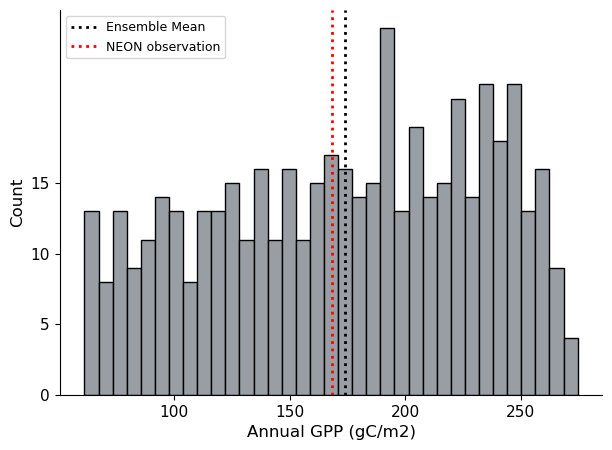

In [185]:
plot_histogram(gpp_sum, gpp_sum_obs, 'Annual GPP', 'gC/m2')

## Train and Test Emulators

### First Train and Test an Emulator

In [186]:
# train
X_test, X_train, y_test, y_train = split_dataset(gpp_sum, ppe_params, n_test)
gpp_sum_em = tr.make_emulator(num_params, X_train, y_train)

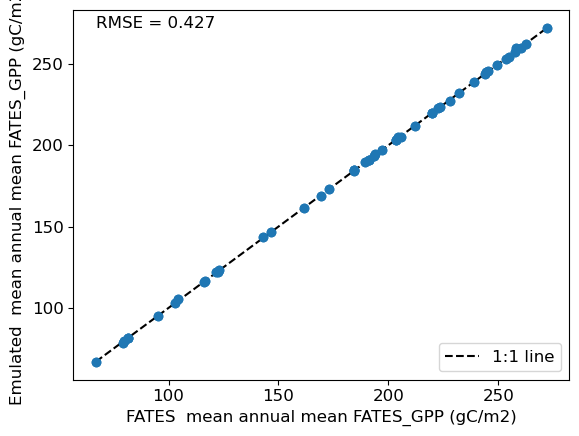

In [187]:
# test it
gpp_sum_em_validation = tr.test_emulator(gpp_sum_em, X_test, y_test, "FATES_GPP")
tr.plot_emulator_validation(gpp_sum_em_validation, "FATES_GPP", "gC/m2", "")

### Do Some Initial Testing

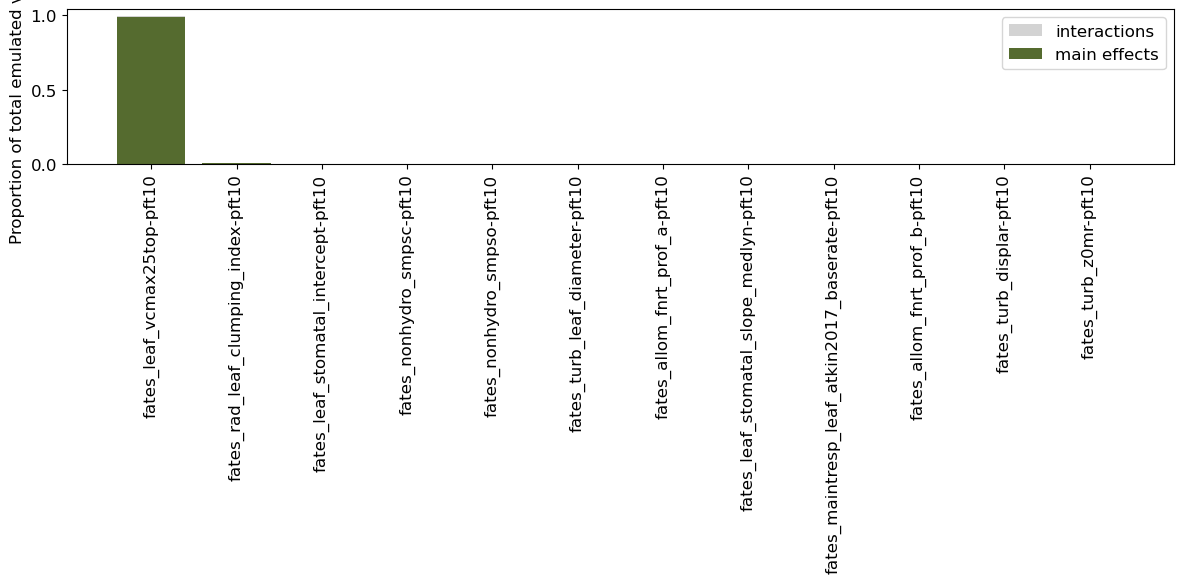

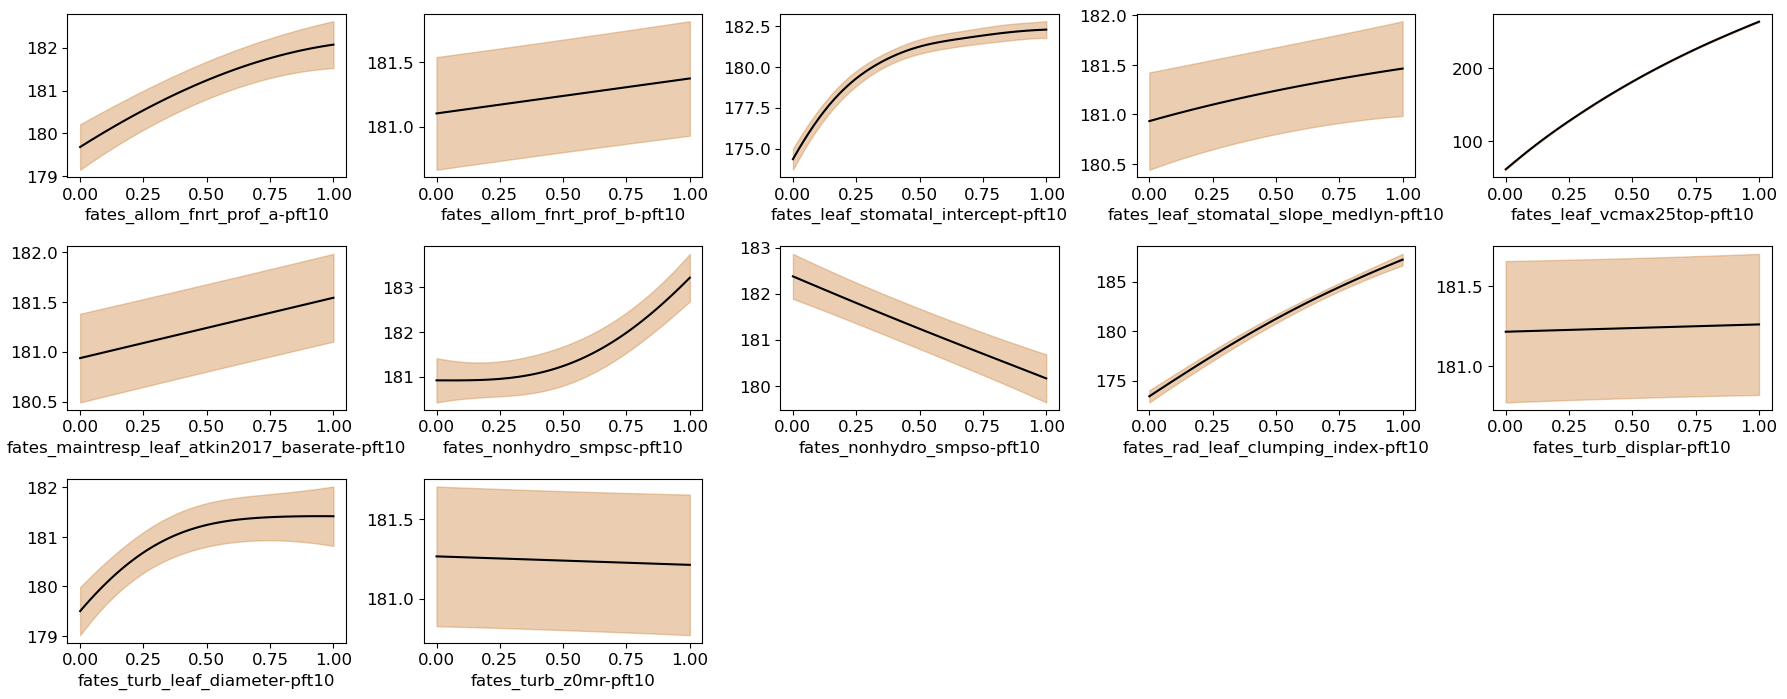

In [234]:
## Sensitivity Analyses
sens_df, oaat_df = sensitivity_analysis(gpp_sum_em, param_names, 'GPP')

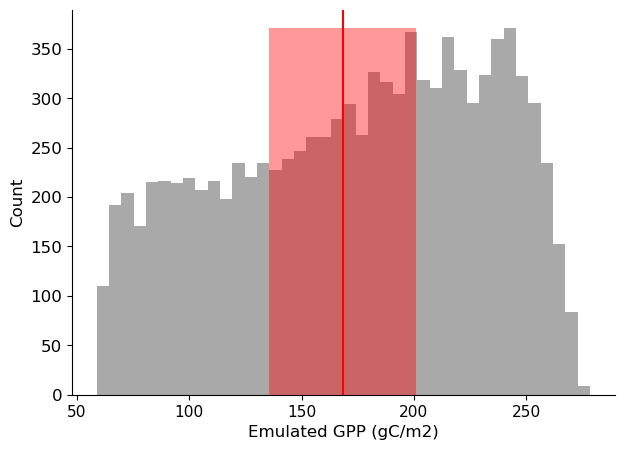

In [215]:
# Sample Emulator
sample_df = sample_emulators(gpp_sum_em, param_names, n_samp,
                             gpp_sum_obs, gpp_var_obs, 'GPP', 'gC/m2')

## Calibrate

In [221]:
implausibility_tol = 1.0
sens_tol = 0.01

## WAVE ONE

In [238]:
best_sample = choose_params(sample_df, sens_df, ['GPP'], implausibility_tol, sens_tol)
best_sample

,fates_leaf_vcmax25top-pft10
0,0.453774


In [239]:
update_vars = best_sample

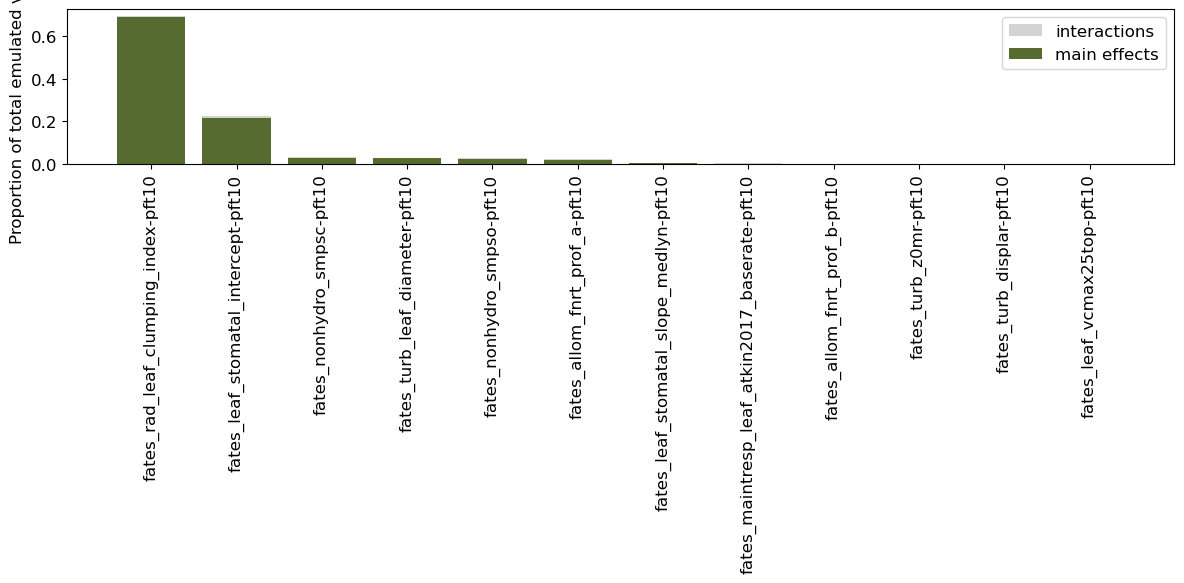

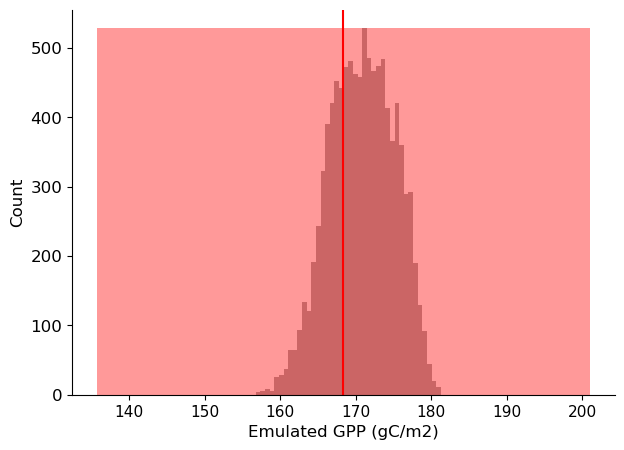

In [243]:
sens_df, _ = sensitivity_analysis(gpp_sum_em, param_names, 'GPP', update_vars=update_vars, plot_oaat=False)
sample_df = sample_emulators(gpp_sum_em, param_names, n_samp, gpp_sum_obs, gpp_var_obs, 'GPP', 'gC/m2', update_vars=update_vars)

In [248]:
best_sample = choose_params(sample_df, sens_df, ['GPP'], implausibility_tol, sens_tol, diff_tol=0.1)

In [249]:
best_sample

,fates_allom_fnrt_prof_a-pft10,fates_leaf_stomatal_intercept-pft10,fates_nonhydro_smpsc-pft10,fates_nonhydro_smpso-pft10,fates_rad_leaf_clumping_index-pft10,fates_turb_leaf_diameter-pft10
0,0.91379,0.283385,0.567371,0.381227,0.224251,0.62202


In [250]:
update_vars = pd.concat([update_vars, best_sample], axis=1)

## WAVE TWO

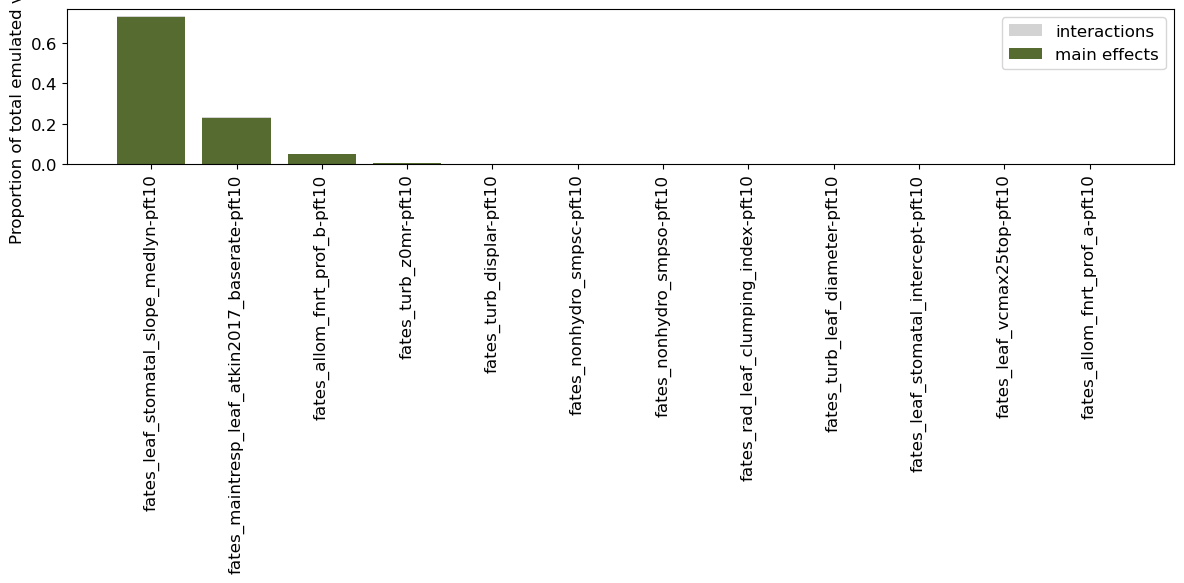

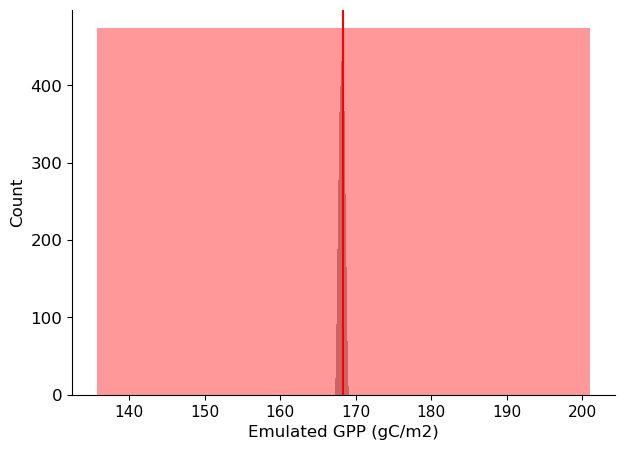

In [251]:
sens_df, _ = sensitivity_analysis(gpp_sum_em, param_names, 'GPP', update_vars=update_vars, plot_oaat=False)
sample_df = sample_emulators(gpp_sum_em, param_names, n_samp, gpp_sum_obs, gpp_var_obs, 'GPP', 'gC/m2', update_vars=update_vars)

In [252]:
best_sample = choose_params(sample_df, sens_df, ['GPP'], implausibility_tol, sens_tol, diff_tol=0.1)

In [253]:
best_sample